# Project 2：預測鐵達尼號乘客的存活率 （Kaggle）

### Part 1: EDA

1.1 匯入資料

1.2 資料結構

1.3 資料完整性

1.4 資料合併

1.5 重要變數探索

### Part 2: Data Cleaning / Feature Engineering

2.1 資料預處理： NA 值

2.2 資料預處理：categorical → numerical

### Part 3: Predictive Modeling

--------------------------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None

# Part 1: EDA

## 1.1 匯入資料

In [2]:
train = pd.read_csv('./data/titanicTrain.csv', dtype={'age': np.float16})
test = pd.read_csv('./data/titanicQuestion.csv', dtype={'age': np.float16})

## 1.2 資料結構

檢視資料結構。

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
pclass       1000 non-null int64
survived     1000 non-null int64
name         1000 non-null object
sex          1000 non-null object
age          861 non-null float16
sibsp        1000 non-null int64
parch        1000 non-null int64
ticket       1000 non-null object
fare         1000 non-null float64
cabin        283 non-null object
embarked     998 non-null object
boat         417 non-null object
body         95 non-null float64
home.dest    742 non-null object
dtypes: float16(1), float64(2), int64(4), object(7)
memory usage: 103.6+ KB


In [4]:
train.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.000000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.916504,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.000000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.000000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.000000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## 1.3 資料完整性

In [5]:
train.isnull().sum().to_frame('NAs')

,NAs
pclass,0
survived,0
name,0
sex,0
age,139
sibsp,0
parch,0
ticket,0
fare,0
cabin,717


所有變數中，cabin、boat、body及home.dest的資料都相當稀疏，另外 age 也有百餘筆 NA 值，embarked 則少了兩筆。

## 1.4 資料合併

先將 train 和 test 兩個資料合併，方便後續進行資料處理和分析。最後會在 train data 前把 test 從中移除。

In [6]:
data = train.append(test)
data.reset_index(inplace=True, drop=True)

## 1.5 重要變數探索

In [7]:
data['survived'] = data['survived'].astype('category') # convert to categorical type
data['sex'] = data['sex'].astype('category') # convert to categorical type
data['pclass'] = data['pclass'].astype('category', ordered=True, categories=[1,2,3]) # convert to ordered categorical type

### 1.5.1 應變數：Survived

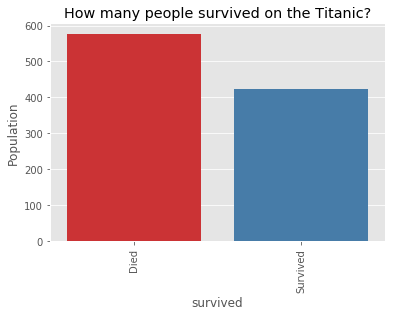

In [8]:
ax = sns.countplot(x='survived', data=data, palette='Set1')
ax.set_title("How many people survived on the Titanic?")
ax.set_xticklabels(["Died","Survived"], rotation='vertical')
ax.set_ylabel("Population")
plt.show()

### 1.5.2 自變數：Sex

結論：女性乘客存活率遠高於男性，將近四倍！

In [9]:
print("Percentage of Female who survived:%.2f"%(data["survived"][data["sex"]=="female"].value_counts(normalize=True)[1]*100))
print("Percentage of Male who survived:%.2f"%(data["survived"][data["sex"]=="male"].value_counts(normalize=True)[1]*100))

Percentage of Female who survived:78.17
Percentage of Male who survived:21.14


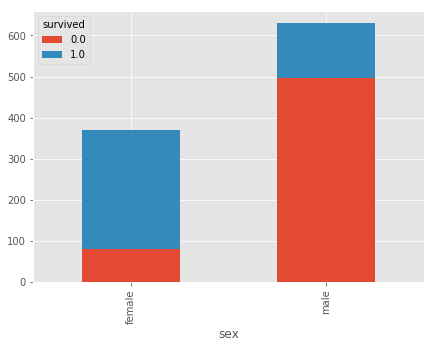

In [10]:
data_sex = data.groupby(['sex', 'survived'])['sex'].count()
data_sex = data_sex.unstack('survived').fillna(0)
data_sex.plot.bar(stacked=True, figsize=(7,5))
plt.show()

### 1.5.3 自變數：Pclass

結論：乘客社會階級越高存活率越大，其中 Class 1 的乘客存活率超過六成。

In [11]:
print("Percentage of Pclass = 1 who survived:%.2f"%(data["survived"][data["pclass"]==1].value_counts(normalize=True)[1]*100))
print("Percentage of Pclass = 2 who survived:%.2f"%(data["survived"][data["pclass"]==2].value_counts(normalize=True)[1]*100))
print("Percentage of Pclass = 3 who survived:%.2f"%(data["survived"][data["pclass"]==3].value_counts(normalize=True)[1]*100))

Percentage of Pclass = 1 who survived:61.92
Percentage of Pclass = 2 who survived:42.96
Percentage of Pclass = 3 who survived:26.00


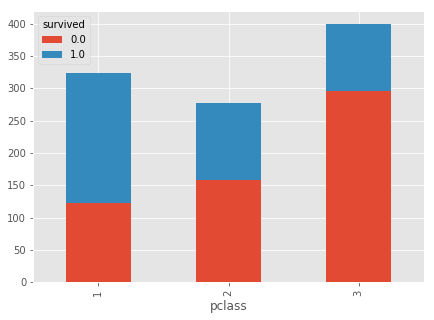

In [12]:
data_pclass = data.groupby(['pclass', 'survived'])['pclass'].count()
data_pclass = data_pclass.unstack('survived').fillna(0)
data_pclass.plot.bar(stacked=True, figsize=(7,5))
plt.show()

### 1.5.4 自變數：parch、sibsp → 親屬關係

+ **parch**：父母與子女數

結論：父母與子女數在1~3人的存活率較高，近六成。

In [13]:
print("Percentage of parch = 0 who survived:%.2f"%(data["survived"][data["parch"]==0].value_counts(normalize=True)[1]*100))
print("Percentage of parch = 1 who survived:%.2f"%(data["survived"][data["parch"]==1].value_counts(normalize=True)[1]*100))
print("Percentage of parch = 2 who survived:%.2f"%(data["survived"][data["parch"]==2].value_counts(normalize=True)[1]*100))
print("Percentage of parch = 3 who survived:%.2f"%(data["survived"][data["parch"]==3].value_counts(normalize=True)[1]*100))
print("Percentage of parch = 4 who survived:%.2f"%(data["survived"][data["parch"]==4].value_counts(normalize=True)[1]*100))
print("Percentage of parch = 5 who survived:%.2f"%(data["survived"][data["parch"]==5].value_counts(normalize=True)[1]*100))
print("Percentage of parch = 6 who survived:%.2f"%(data["survived"][data["parch"]==6].value_counts(normalize=True)[1]*100))

Percentage of parch = 0 who survived:36.61
Percentage of parch = 1 who survived:65.38
Percentage of parch = 2 who survived:57.14
Percentage of parch = 3 who survived:62.50
Percentage of parch = 4 who survived:33.33
Percentage of parch = 5 who survived:25.00
Percentage of parch = 6 who survived:0.00


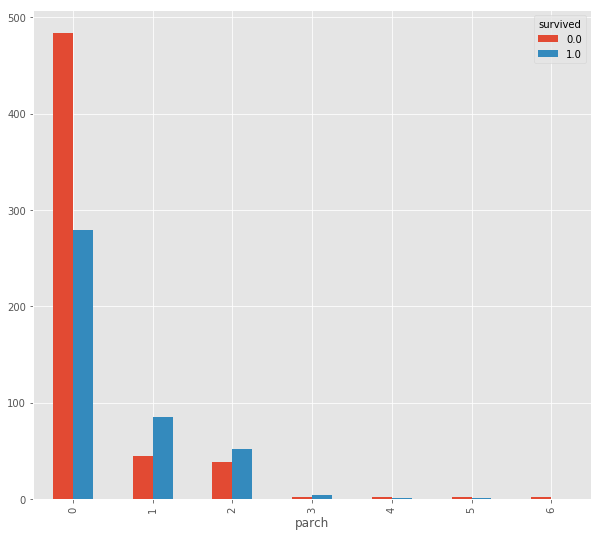

In [14]:
data_parch = data.groupby(['parch', 'survived'])['parch'].count()
data_parch = data_parch.unstack('survived').fillna(0)
data_parch.plot.bar(stacked=False, figsize=(10,9))
plt.show()

+ **sibsp**：配偶與兄弟姊妹數

結論：配偶與兄弟姊妹數在1~3人的存活率近五成。

In [15]:
print("Percentage of sibsp = 0 who survived:%.2f"%(data["survived"][data["sibsp"]==0].value_counts(normalize=True)[1]*100))
print("Percentage of sibsp = 1 who survived:%.2f"%(data["survived"][data["sibsp"]==1].value_counts(normalize=True)[1]*100))
print("Percentage of sibsp = 2 who survived:%.2f"%(data["survived"][data["sibsp"]==2].value_counts(normalize=True)[1]*100))
print("Percentage of sibsp = 3 who survived:%.2f"%(data["survived"][data["sibsp"]==3].value_counts(normalize=True)[1]*100))
print("Percentage of sibsp = 4 who survived:%.2f"%(data["survived"][data["sibsp"]==4].value_counts(normalize=True)[1]*100))
print("Percentage of sibsp = 5 who survived:%.2f"%(data["survived"][data["sibsp"]==5].value_counts(normalize=True)[1]*100))

Percentage of sibsp = 0 who survived:38.38
Percentage of sibsp = 1 who survived:52.59
Percentage of sibsp = 2 who survived:47.06
Percentage of sibsp = 3 who survived:54.55
Percentage of sibsp = 4 who survived:25.00
Percentage of sibsp = 5 who survived:0.00


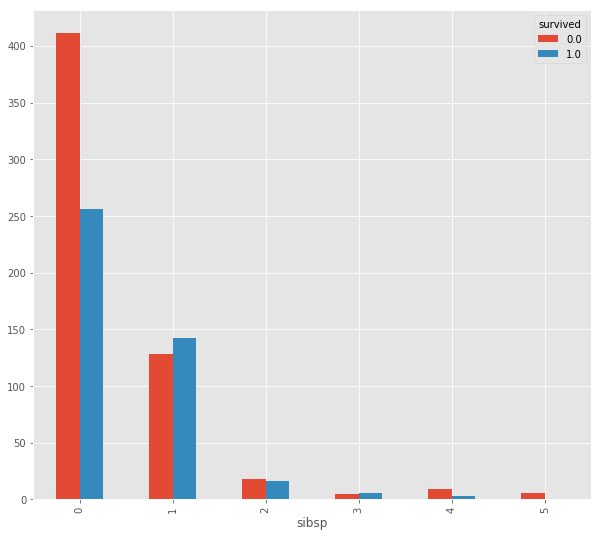

In [16]:
data_sibsp = data.groupby(['sibsp', 'survived'])['sibsp'].count()
data_sibsp = data_sibsp.unstack('survived').fillna(0)
data_sibsp.plot.bar(stacked=False, figsize=(10,9))
plt.show()

+ **family_size**：合併上述兩樣變數，成新的自變數 family_size，表示所有親屬。

結論：親屬數為5及7人者存活率特別高，超過七成。

In [17]:
data['family_size'] = data['parch'] + data['sibsp']

In [18]:
print("Percentage of family_size = 0 who survived:%.2f"%(data["survived"][data["family_size"]==0].value_counts(normalize=True)[1]*100))
print("Percentage of family_size = 1 who survived:%.2f"%(data["survived"][data["family_size"]==1].value_counts(normalize=True)[1]*100))
print("Percentage of family_size = 2 who survived:%.2f"%(data["survived"][data["family_size"]==2].value_counts(normalize=True)[1]*100))
print("Percentage of family_size = 3 who survived:%.2f"%(data["survived"][data["family_size"]==3].value_counts(normalize=True)[1]*100))
print("Percentage of family_size = 4 who survived:%.2f"%(data["survived"][data["family_size"]==4].value_counts(normalize=True)[1]*100))
print("Percentage of family_size = 5 who survived:%.2f"%(data["survived"][data["family_size"]==5].value_counts(normalize=True)[1]*100))
print("Percentage of family_size = 6 who survived:%.2f"%(data["survived"][data["family_size"]==6].value_counts(normalize=True)[1]*100))
print("Percentage of family_size = 7 who survived:%.2f"%(data["survived"][data["family_size"]==7].value_counts(normalize=True)[1]*100))

Percentage of family_size = 0 who survived:33.39
Percentage of family_size = 1 who survived:54.90
Percentage of family_size = 2 who survived:58.20
Percentage of family_size = 3 who survived:71.43
Percentage of family_size = 4 who survived:35.29
Percentage of family_size = 5 who survived:71.43
Percentage of family_size = 6 who survived:25.00
Percentage of family_size = 7 who survived:0.00


In [19]:
data['family_size'] = data['parch'] + data['sibsp']

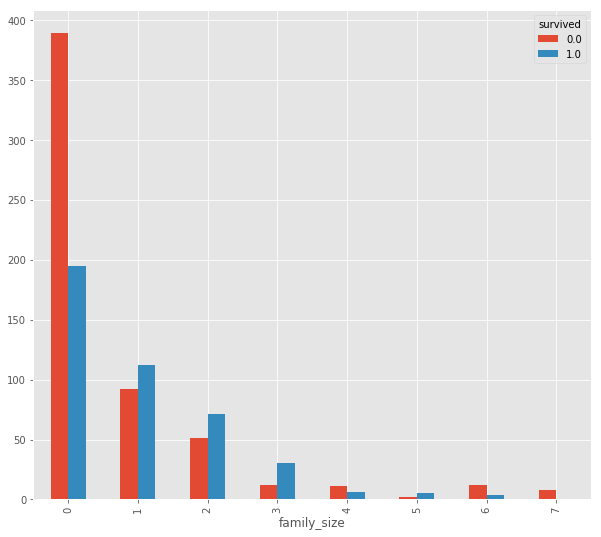

In [20]:
data_fam = data.groupby(['family_size', 'survived'])['family_size'].count()
data_fam = data_fam.unstack('survived').fillna(0)
data_fam.plot.bar(stacked=False, figsize=(10,9))
plt.show()

### 1.5.5 自變數：age

結論：年輕族群（0-20歲）的存活率高於死亡率。

C:\Users\jestw\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


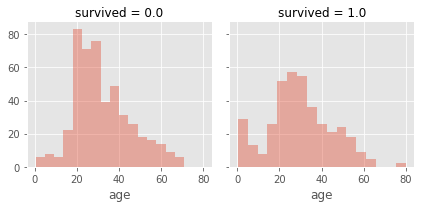

In [21]:
g = sns.FacetGrid(data, col='survived')
g.map(sns.distplot, 'age', kde=False)

### 1.5.6 自變數：fare

結論：票價越高者，存活率越高。

<bound method Grid.add_legend of <seaborn.axisgrid.FacetGrid object at 0x0000028ACA46C4A8>>

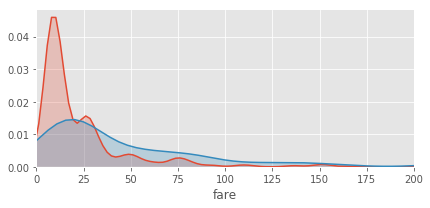

In [22]:
facet=sns.FacetGrid(data,hue="survived",aspect=2)
facet.map(sns.kdeplot,'fare',shade=True)
facet.set(xlim=(0,200))
facet.add_legend

### 1.5.7 自變數：name → 稱謂 + 姓名

Step 1：將稱謂從名字中取出，存在欄位 title1。 

Step 2：比對稱謂和性別、年紀的關係。

#Step 3：替換掉多餘的稱謂：給予性別、年紀相仿者相同的稱謂。

#Step 4：檢視最後剩下來的稱謂：Master、Miss、Mr、Mrs。

In [23]:
# Step 1
data['title1'] = data['name'].str.split(", ", expand=True)[1]
data['title1'] = data['title1'].str.split(".", expand=True)[0]
data['title1'].unique()

array(['Miss', 'Master', 'Mr', 'Mrs', 'Col', 'Mme', 'Dr', 'Major', 'Capt',
       'Lady', 'Sir', 'Mlle', 'Dona', 'Jonkheer', 'the Countess', 'Don',
       'Rev', 'Ms'], dtype=object)

In [24]:
data.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1
0,1,1.0,"Allen, Miss. Elisabeth Walton",female,29.000000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",0,Miss
1,1,1.0,"Allison, Master. Hudson Trevor",male,0.916504,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",3,Master
2,1,0.0,"Allison, Miss. Helen Loraine",female,2.000000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",3,Miss


In [25]:
# Step 2: title vs sex
pd.crosstab(data['title1'],data['sex']).T.style.background_gradient(cmap='summer_r')

title1,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [26]:
# Step 2: title vs age
data.groupby(['title1'])['age'].median()

title1
Capt            70.0
Col             54.5
Don             40.0
Dona            39.0
Dr              49.0
Jonkheer        38.0
Lady            48.0
Major           48.5
Master           4.0
Miss            22.0
Mlle            24.0
Mme             24.0
Mr              29.0
Mrs             35.5
Ms              28.0
Rev             41.5
Sir             49.0
the Countess    33.0
Name: age, dtype: float16

In [27]:
# Step 3:
#data['title2'] = data['title1'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
         #['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Mr','Mrs'])
#data['title2'].unique()

In [28]:
# Step 4:
#data.groupby(['title2'])['age'].median()

# Part 2: Data Cleaning / Feature Engineering

## 2.1 資料預處理： NA 值

### 2.1.1 自變數：age

從上一段分析可以看出不同稱謂的乘客年齡分布不同，因此我們根據稱謂區分，算出中位數，填補年齡的 NA 值。

In [29]:
# Miss.、Ms.、Mrs
mask =  (data["age"].isnull()) & ( (data['name'].str.contains("Ms.")) | (data['name'].str.contains("Miss.")) )
mask2 = ( (data['name'].str.contains("Ms.")) | (data['name'].str.contains("Miss.")) )
data.loc[mask,'age'] = data.loc[mask,'age'].fillna(data.loc[mask2,'age'].median())

In [30]:
# Mr.、Major、Sir
mask =  (data["age"].isnull()) & ( (data['name'].str.contains("Mr.")) | (data['name'].str.contains("Sir.")) | (data['name'].str.contains("Major")) )
mask2 =  ( (data['name'].str.contains("Mr.")) | (data['name'].str.contains("Sir.")) | (data['name'].str.contains("Major")) )
data.loc[mask,'age'] = data.loc[mask,'age'].fillna(data.loc[mask2,'age'].median())

In [31]:
# Master
mask =  (data["age"].isnull()) & ( data['name'].str.contains("Master.") )
data.loc[mask,'age'] = data.loc[mask,'age'].fillna(data[data['name'].str.contains("Master.")]["age"].median())

In [32]:
# Dr
mask =  (data["age"].isnull()) & ( data['name'].str.contains("Dr\.") )
data.loc[mask,'age'] = data.loc[mask,'age'].fillna(data[data['name'].str.contains("Dr\.")]["age"].median())

確認年齡資料補齊，不再有 NA 值。

In [33]:
data[data['age'].isnull()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1


### 2.1.2 自變數：embarked

In [41]:
# examine data type first
data['survived'].dtypes

category

In [189]:
# since groupby only accepts numerical data, convert
data_emb = data[['embarked', 'survived','pclass']]
pd.to_numeric(data_emb['survived'], errors='ignore').head()

0    1.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: survived, dtype: float64

+ **embarked VS survived**

檢視上船地點（embarked）與存活率的關係。

In [186]:
emb_s = data_emb[['embarked', 'survived']].set_index('embarked').notnull().groupby(level=0).mean()
emb_s = emb_s.sort_values(by='survived', ascending=False)
emb_s = emb_s.reset_index()
emb_s = emb_s.rename(columns={'survived': 'rate'})

total = data_emb[['embarked', 'survived']].set_index('embarked').notnull().groupby(level=0).count()
total = total.reset_index()
total = total.rename(columns={'survived': 'total'})

survive = data_emb[['embarked', 'survived']].set_index('embarked').notnull().groupby(level=0).sum()
survive = survive.reset_index()

emb_s['survived'] = survive_emb['survived'].astype(int)
emb_s['total'] = total['total']
emb_s['died'] = emb_s['total'] - emb_s['survived']
emb_s

,embarked,rate,survived,total,died
0,C,0.829630,224,270,46
1,S,0.769147,71,123,52
2,Q,0.577236,703,914,211


In [190]:
data_emb = data_emb.dropna(subset=['survived'])

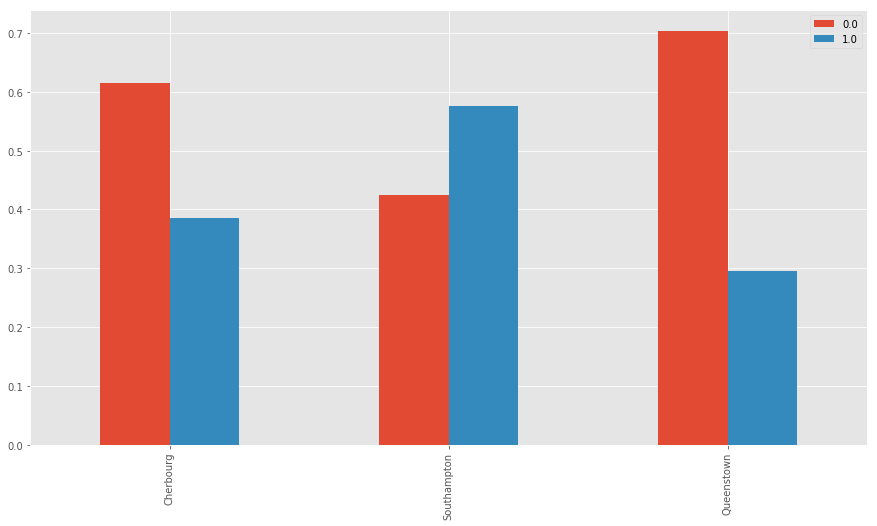

In [187]:
total_Embarked_C = data_emb[data_emb['embarked']=='C']['survived'].count()
total_Embarked_S = data_emb[data_emb['embarked']=='S']['survived'].count()
total_Embarked_Q = data_emb[data_emb['embarked']=='Q']['survived'].count()

Embarked_C = data_emb[data_emb['embarked']=='C']['survived'].value_counts() / total_Embarked_C
Embarked_S = data_emb[data_emb['embarked']=='S']['survived'].value_counts() / total_Embarked_S
Embarked_Q = data_emb[data_emb['embarked']=='Q']['survived'].value_counts() / total_Embarked_Q  
           
df = pd.DataFrame([Embarked_S,Embarked_C,Embarked_Q])
df.index = ['Cherbourg','Southampton','Queenstown']
df.plot(kind='bar',stacked=False, figsize=(15,8))

+ **embarked VS pclass**

檢視上船地點（embarked）與 pclass 的關係。

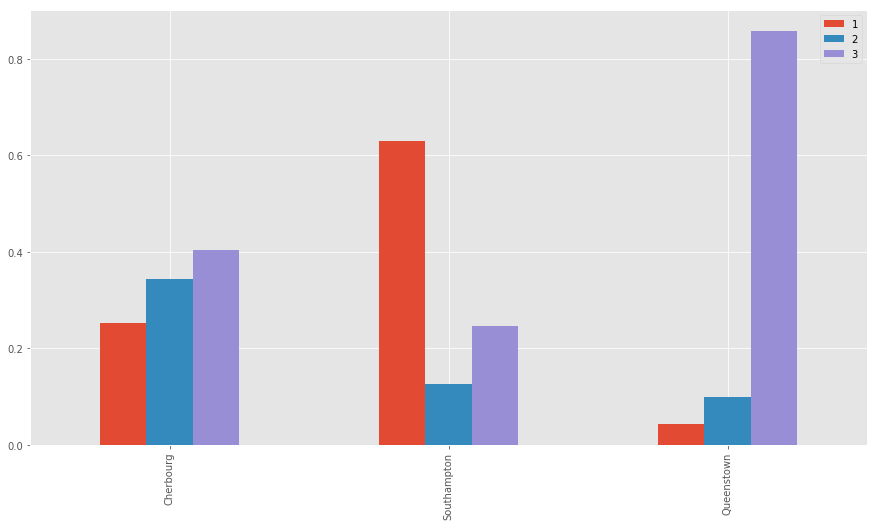

In [191]:
total_Embarked_C = data_emb[data_emb['embarked']=='C']['pclass'].count()
total_Embarked_S = data_emb[data_emb['embarked']=='S']['pclass'].count()
total_Embarked_Q = data_emb[data_emb['embarked']=='Q']['pclass'].count()

Embarked_C = data_emb[data_emb['embarked']=='C']['pclass'].value_counts() / total_Embarked_C
Embarked_S = data_emb[data_emb['embarked']=='S']['pclass'].value_counts() / total_Embarked_S
Embarked_Q = data_emb[data_emb['embarked']=='Q']['pclass'].value_counts() / total_Embarked_Q  

df = pd.DataFrame([Embarked_S,Embarked_C,Embarked_Q])
df.index = ['Cherbourg','Southampton','Queenstown']
df.plot(kind='bar',stacked=False, figsize=(15,8))

填補 NA 值。從 Cherbourg 港口上岸的乘客比起其它港口,有較大的比例為P1等級的船票，剛好這兩位乘客的船票等級（Pclass）都是1，因此，我們就直接假設她們的上岸港口為 Cherbourg 。

In [193]:
data.loc[(data.embarked.isnull())] 

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1
168,1,1.0,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,6,NaN,NaN,0,Miss
284,1,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,6,NaN,"Cincinatti, OH",0,Mrs


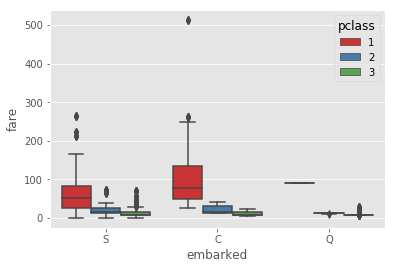

In [194]:
sns.boxplot(x="embarked",y="fare",hue="pclass",data=data,palette="Set1")

In [227]:
def fill_Embarked():
    data['embarked'].fillna("C", inplace=True)
fill_Embarked()

### 2.1.3 自變數：fare

填補 NA 值。我們直接用中位數來填入，因為從前面的分析中，很難確定 Fare 與何種欄位相關。

In [195]:
data.loc[(data.fare.isnull())] 

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1
1225,3,NaN,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,NaN,261.0,NaN,0,Mr


In [223]:
def fill_Fare():
      data['fare'].fillna(data['fare'].median(), inplace=True)
fill_Fare()

### 2.1.4 自變數：title1 簡化

In [197]:
data['title2'] = data['title1'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
         ['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Mr','Mrs'])
data['title2'].unique()

array(['Miss', 'Master', 'Mr', 'Mrs'], dtype=object)

## 2.2 資料預處理：categorical → numerical

因為多數機器學習演算法指接受 numerical data ，所以將所有非數值型資料透過 **One-Hot Encoding** 進行編碼。其中屬於 categorical data 的變數包含：sex、pclass、ticket、cabin、embarked、title。

In [198]:
def oneHotEncode():
    global data
    data['sex'] = data['sex'].astype('category').cat.codes
    data['embarked'] = data['embarked'].astype('category').cat.codes
    data['pclass'] = data['pclass'].astype('category').cat.codes
    data['title2'] = data['title2'].astype('category').cat.codes
    data['ticket'] = data['ticket'].astype('category').cat.codes
oneHotEncode()

In [199]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,family_size,title1,title2
0,0,1.0,"Allen, Miss. Elisabeth Walton",0,29.000000,0,0,187,211.3375,B5,2,2,NaN,"St Louis, MO",0,Miss,1
1,0,1.0,"Allison, Master. Hudson Trevor",1,0.916504,1,2,49,151.5500,C22 C26,2,11,NaN,"Montreal, PQ / Chesterville, ON",3,Master,0
2,0,0.0,"Allison, Miss. Helen Loraine",0,2.000000,1,2,49,151.5500,C22 C26,2,NaN,NaN,"Montreal, PQ / Chesterville, ON",3,Miss,1
3,0,0.0,"Allison, Mr. Hudson Joshua Creighton",1,30.000000,1,2,49,151.5500,C22 C26,2,NaN,135.0,"Montreal, PQ / Chesterville, ON",3,Mr,2
4,0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0,25.000000,1,2,49,151.5500,C22 C26,2,NaN,NaN,"Montreal, PQ / Chesterville, ON",3,Mrs,3


最後，確認除了應變數 survived 外，資料無 NA 值。

In [228]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
pclass         1309 non-null int8
survived       1000 non-null category
sex            1309 non-null int8
age            1309 non-null float16
sibsp          1309 non-null int64
parch          1309 non-null int64
ticket         1309 non-null int16
fare           1309 non-null float64
embarked       1309 non-null int8
family_size    1309 non-null int64
title2         1309 non-null int8
dtypes: category(1), float16(1), float64(1), int16(1), int64(3), int8(4)
memory usage: 52.6 KB


# Part 3: Predictive Modeling

在開始訓練之前，記得將被合併到Train dataset的Test dataset再搬出來。

In [216]:
data.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,embarked,family_size,title2
0,0,1.0,0,29.000000,0,0,187,211.3375,2,0,1
1,0,1.0,1,0.916504,1,2,49,151.5500,2,3,0
2,0,0.0,0,2.000000,1,2,49,151.5500,2,3,1
3,0,0.0,1,30.000000,1,2,49,151.5500,2,3,2
4,0,0.0,0,25.000000,1,2,49,151.5500,2,3,3


In [229]:
#data = data.drop("name", axis=1)
#data = data.drop("body", axis=1)
#data = data.drop("home.dest", axis=1)
#data = data.drop("boat", axis=1)
#data = data.drop("title1", axis=1)
#data = data.drop("cabin", axis=1)


X_train = data.iloc[:1000].drop("survived", axis=1)
Y_train = data.iloc[:1000]["survived"]
X_test  = data.iloc[1000:]
X_test = X_test.drop("survived",axis=1)

X_train.shape, Y_train.shape, X_test.shape

((1000, 10), (1000,), (309, 10))

In [219]:
# 載入scikit-learn相關模組
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, cross_validation

+ Logistic Regression

In [230]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

78.799999999999997

+ Support Vector Machines

In [232]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

98.400000000000006

+ KNN

In [233]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

80.400000000000006

+ Decision Tree

In [234]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree


99.900000000000006

+ Random Forest

In [235]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

99.900000000000006

In [236]:
test.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,3,NaN,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q,NaN,NaN,NaN
1,3,NaN,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
2,3,NaN,"McCoy, Miss. Alicia",female,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
3,3,NaN,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
4,3,NaN,"McDermott, Miss. Brigdet Delia",female,NaN,0,0,330932,7.7875,NaN,Q,13,NaN,NaN


In [237]:
submission = pd.DataFrame({
        "Name": test["name"],
        "Survived": Y_pred
    })

In [239]:
submission.tail(10)

,Name,Survived
299,"Yasbeck, Mr. Antoni",0.0
300,"Yasbeck, Mrs. Antoni (Selini Alexander)",0.0
301,"Youseff, Mr. Gerious",0.0
302,"Yousif, Mr. Wazli",0.0
303,"Yousseff, Mr. Gerious",0.0
304,"Zabour, Miss. Hileni",0.0
305,"Zabour, Miss. Thamine",0.0
306,"Zakarian, Mr. Mapriededer",0.0
307,"Zakarian, Mr. Ortin",0.0
308,"Zimmerman, Mr. Leo",0.0


In [ ]:
test.head(100)